### Task 1

One of the main challenges in quantum computing is the noise in current devices. In this task, you will create a simple noise generator and assess its effect. You can use Qiskit.

### Noise Model
A standard way to represent the noise in a quantum circuit is through Pauli operators (X, Y, Z). Build a function with input parameters `p1`, `p2`, and `QuantumCircuit` where:

- `p1`: Probability of having a random Pauli operator acting on the qubit after a one-qubit gate
- `p2`: Probability of having a random Pauli operator acting on the qubit after a two-qubit gate
- `QuantumCircuit`: Quantum circuit where the noise will be added

The output should be the quantum circuit with noise.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity
from matplotlib import pyplot as plt
from qiskit_experiments.library import StateTomography

In [2]:
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [3]:
def add_pauli_noise(p1, p2):
    noise_model = NoiseModel()

    # Pauli operators: X (bit flip), Y (bit + phase flip), Z (phase flip)
    pauli_1 = pauli_error([('X', p1 / 3), ('Y', p1 / 3), ('Z', p1 / 3), ('I', 1 - p1)])
    pauli_2 = pauli_error([('X', p2 / 3), ('Y', p2 / 3), ('Z', p2 / 3), ('I', 1 - p2)])

    # Add errors to the noise model
    noise_model.add_all_qubit_quantum_error(pauli_1, ['u1', 'u2', 'u3', 'h', 'x', 'y', 'z'])
    noise_model.add_all_qubit_quantum_error(pauli_2.tensor(pauli_2), ['cx'])

    return noise_model

The function `add_pauli_noise(p1, p2)` adds a noise model to a quantum circuit based on Pauli operators. The Pauli operators are commonly used to represent different types of noise in quantum computing:

- **X Gate (Bit Flip)**: Represents a bit-flip error, where the state |0⟩ changes to |1⟩ or vice versa.
- **Y Gate (Bit + Phase Flip)**: Represents both a bit-flip and a phase-flip.
- **Z Gate (Phase Flip)**: Represents a phase-flip error, which changes the phase of the quantum state.

In the given code, the noise model is constructed with the following steps:

1. **Single-Qubit Noise (`pauli_1`)**:
   - The noise `pauli_1` is created with probabilities `p1 / 3` for each of the Pauli operators X, Y, Z, and `(1 - p1)` for the identity (i.e., no error).
   - Mathematically, the noise model can be represented as:
     
     $$
     E_1 = \frac{p_1}{3} X + \frac{p_1}{3} Y + \frac{p_1}{3} Z + (1 - p_1) I
     $$
     
     This means that each of the Pauli operators (X, Y, Z) has an equal probability of occurring, and there is also a probability of no error occurring (represented by the identity operator I).

2. **Two-Qubit Noise (`pauli_2`)**:
   - The noise `pauli_2` is similarly constructed, with probabilities `p2 / 3` for each of the Pauli operators X, Y, Z, and `(1 - p2)` for the identity.
   - Since this noise is applied to a two-qubit gate (`cx`), the tensor product of `pauli_2` with itself is taken to represent independent noise on both qubits involved in the two-qubit gate. Mathematically, this can be represented as:
     
     $$
     E_2 = E_{2,1} \otimes E_{2,2}
     $$
     
     where $E_{2,1} $ and $ E_{2,2} $ represent the noise on the first and second qubits, respectively, and $ \otimes $ denotes the tensor product.

3. **Adding Noise to the Noise Model**:
   - The function `add_all_qubit_quantum_error()` is used to add the noise to all qubits for specific gate operations.
   - The noise `pauli_1` is added to all single-qubit gates (`u1`, `u2`, `u3`, `h`, `x`, `y`, `z`), while the noise `pauli_2` (in tensor form) is added to the two-qubit `cx` gate.

The resulting noise model captures the effects of random Pauli errors occurring after specific gates, which allows for the simulation of a noisy quantum circuit.

Noiseless simulation:
{'11': 510, '00': 514}


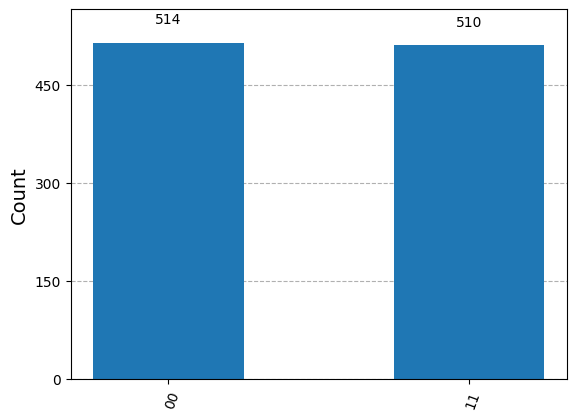

In [4]:
# First run noiseless simulation
simulator = AerSimulator()
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()
result = simulator.run(circuit).result()
counts = result.get_counts()
print("Noiseless simulation:")
print(counts)
display(plot_histogram(counts))

Noisy simulation:
{'01': 74, '11': 453, '10': 47, '00': 450}


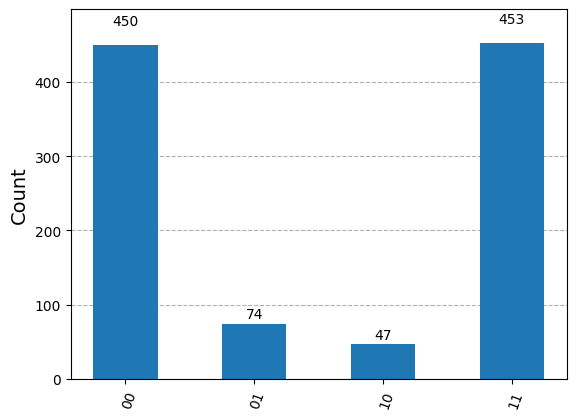

In [5]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

p1 = 0.01 # single qubit gate error rate
p2 = 0.1 # two qubit gate error rate

# Add noise to the circuit
noise_model = add_pauli_noise(p1, p2)
noisy_simulator = AerSimulator(noise_model=noise_model)
noisy_circuit = transpile(qc, noisy_simulator)
result = noisy_simulator.run(noisy_circuit).result()
counts = result.get_counts()
print("Noisy simulation:")
print(counts)
display(plot_histogram(counts))

### Task 2: Gate Basis
Quantum computers can implement only a set of gates that, with transformations, can represent any other possible gate. This set of gates is called the Gate Basis of the QPU. Build a function that transforms a general Quantum Circuit to the following gate basis: `{CX, ID, RZ, SX, X}`.

In [6]:
def transform_to_gate_basis(qc):
    # Define the target gate basis
    basis_gates = ['cx', 'id', 'rz', 'sx', 'x']
    
    # Transpile the circuit to the target basis
    transpiled_qc = transpile(qc, basis_gates=basis_gates)
    return transpiled_qc

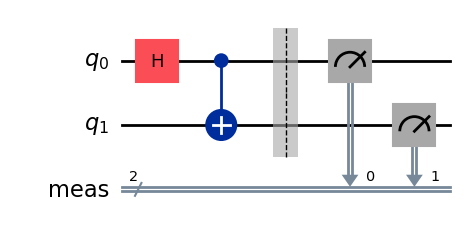

In [7]:
#plot the circuit without basis transformation
qc.draw('mpl')

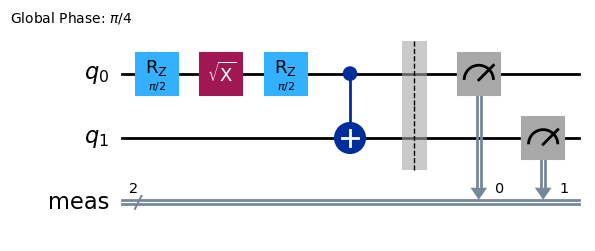

In [8]:
#plot the circuit with basis transformation
qc.draw('mpl')
transform_to_gate_basis(qc).draw('mpl')

### Task 3: Adding Two Numbers with a Quantum Computer

In this task, we use the Draper adder algorithm to add two numbers using a quantum circuit. The key component of this algorithm is the Quantum Fourier Transform (QFT), which is used to encode and manipulate phase information for quantum addition.

**Quantum Sum Function (`quantum_sum`)**

The `quantum_sum` function takes two integers `a` and `b` as input and outputs a quantum circuit that adds these numbers using the following steps:

1. **Initialization**:
   - Determine the number of qubits required (`n`), which is one more than the bit length of the larger number (`a` or `b`), to account for potential carry bits.
   - Create a quantum circuit with `2 * n` qubits and `n` classical bits for measurement.

2. **Loading Values**:
   - Encode the binary representation of `a` and `b` into the first `n` qubits and the next `n` qubits respectively. This is done using `X` gates to set each qubit to the state corresponding to `1` in the binary representation.

3. **Quantum Fourier Transform (QFT)**:
   - Apply the QFT to the first register (first `n` qubits) to prepare them for addition in the quantum Fourier space. The QFT transforms the computational basis states into superpositions, allowing us to manipulate the quantum phases efficiently.

4. **Controlled Phase Rotations**:
   - Apply controlled phase gates to add the value of `b` to the first register in the Fourier space. This involves a series of controlled rotations between the qubits in the second register (representing `b`) and the qubits in the first register.

5. **Inverse QFT**:
   - Apply the inverse QFT to the first register to convert the state back to the computational basis, which results in the sum of `a` and `b` being represented in the first `n` qubits.

6. **Measurement**:
   - Measure the first `n` qubits to obtain the result of the addition.

In [9]:
def qft(n):
    qc = QuantumCircuit(n)
    for j in range(n):
        qc.h(j)
        for k in range(j + 1, n):
            qc.cp(np.pi / 2**(k - j), k, j)  # Apply controlled phase gate
    return qc

In [10]:
def qft(n):
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)
        for j in range(i + 1, n):
            angle = np.pi / 2**(j - i)
            qc.cp(angle, i, j)  # Apply controlled phase gate from qubit i to qubit j
    for i in range(n // 2):
        qc.swap(i, n - i - 1)  # Swap qubits to reverse order
    return qc

# Draper Adder Algorithm for Quantum Sum
def quantum_sum(a, b):
    n = max(a.bit_length(), b.bit_length()) + 1  # Number of qubits needed
    qc = QuantumCircuit(2 * n, n)  # Add classical bits for measurement

    # Load the values into the qubits
    for i in range(a.bit_length()):
        if (a >> i) & 1:
            qc.x(i)
    for i in range(b.bit_length()):
        if (b >> i) & 1:
            qc.x(n + i)

    # Apply QFT to the first register
    qc.append(qft(n), range(n))

    # Apply controlled phase rotations for addition
    for i in range(n):
        for j in range(i + 1):
            if (b >> j) & 1:
                qc.cp(2 * np.pi / 2**(i - j + 1), n + j, i)

    # Apply inverse QFT to the first register
    qc.append(qft(n).inverse(), range(n))

    # Measure the result
    qc.measure(range(n), range(n))
    return qc

In [11]:
qc_sum = quantum_sum(3, 5)
print(qc_sum)

     ┌───┐┌──────────────┐                                                  »
q_0: ┤ X ├┤0             ├─■────────────────────────────────────────────────»
     ├───┤│              │ │                                                »
q_1: ┤ X ├┤1             ├─┼──────■─────────────────────────────────────────»
     └───┘│  circuit-302 │ │      │                                         »
q_2: ─────┤2             ├─┼──────┼────────■────────■───────────────────────»
          │              │ │      │        │        │                       »
q_3: ─────┤3             ├─┼──────┼────────┼────────┼──────■────────■───────»
     ┌───┐└──────────────┘ │P(π)  │P(π/2)  │P(π/4)  │      │P(π/8)  │       »
q_4: ┤ X ├─────────────────■──────■────────■────────┼──────■────────┼───────»
     └───┘                                          │               │       »
q_5: ───────────────────────────────────────────────┼───────────────┼───────»
     ┌───┐                                          │P(π)       

{'1000': 8192}


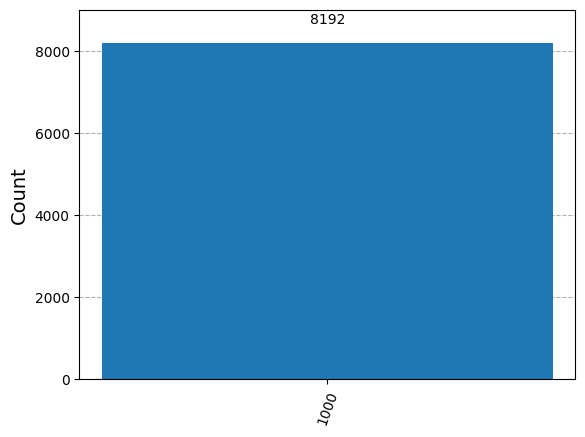

In [12]:
# Simulate the circuit and get the result
backend = AerSimulator()
shots = 8192
transpiled_qc_sum = transpile(qc_sum, backend)
result = backend.run(transpiled_qc_sum, shots=shots).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

In [13]:
# Verify if the sum is correct
expected_sum = 3 + 5
expected_binary = format(expected_sum, f'0{qc_sum.num_clbits}b')
most_frequent_result = max(counts, key=counts.get)

if most_frequent_result == expected_binary:
    print(f"The sum is correct: {expected_sum} (binary: {expected_binary})")
else:
    print(f"The sum is incorrect. Expected {expected_binary} but got {most_frequent_result}")

The sum is correct: 8 (binary: 1000)


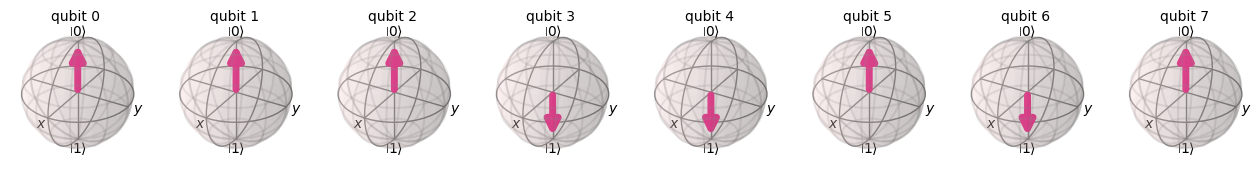

In [14]:
# Visualize the state on Bloch sphere before measurement
qc_sum_no_measure = quantum_sum(3, 5)
qc_sum_no_measure.remove_final_measurements()
state = Statevector.from_instruction(qc_sum_no_measure)
plot_bloch_multivector(state)

### Task 4: Effects of Noise on Quantum Addition

In this task, we analyze the effects of noise on the quantum addition performed in Task 3. We add noise to the quantum circuit used in `quantum_sum` and evaluate how different levels of noise impact the results.

**Objectives**:

- Add noise to the quantum circuit using the gate basis.
- Use different noise levels and analyze how the results are affected.
- Address the following questions:
  - How does the noise affect the results?
  - Is there a way to decrease the effect of noise?
  - How does the number of gates used affect the results?

In [15]:
def qc_with_noise(a, b, p1, p2):
    # Generate quantum sum circuit
    qc_sum = quantum_sum(a, b)

    # Transform to gate basis
    qc_sum = transform_to_gate_basis(qc_sum)

    # Add noise to the circuit
    noise_model = add_pauli_noise(p1, p2)

    return noise_model


In [34]:
qc_no_noise = quantum_sum(3, 5)
qc_no_noise = transform_to_gate_basis(qc_no_noise)
backend = AerSimulator()
result = backend.run(qc_no_noise).result()
#obtain a staevector from the counts
ideal = result.get_counts()
# Convert ideal counts to probabilities
total_ideal = sum(ideal.values())
ideal_probs = {k: v / total_ideal for k, v in ideal.items()}

The fidelity $ F $ between two probability distributions $ p $ and $ q $ over the same set of outcomes is given by:

$$
F(p, q) = \left( \sum_{i} \sqrt{p_i \cdot q_i} \right)^2
$$

Where:
- $ p_i $ is the probability of the $ i $-th outcome in the ideal distribution.
- $ q_i $ is the probability of the $ i $-th outcome in the noisy distribution.


In [35]:
def calculate_fidelity(ideal_probs, noisy_counts):
    total_noisy = sum(noisy_counts.values())
    noisy_probs = {k: v / total_noisy for k, v in noisy_counts.items()}
    fidelity = sum((ideal_probs.get(k, 0) * noisy_probs.get(k, 0))**0.5 for k in set(ideal_probs) | set(noisy_probs))
    return fidelity ** 2

In [36]:
# Simulate the circuit with noise P1 only and get the result
a = 3
b = 5
p1 = np.linspace(0, 0.1, 11)
p2 = 0.0
shots = 8192
results = []
for p in p1:
    noise_model = add_pauli_noise(p, p2)
    noisy_simulator = AerSimulator(noise_model=noise_model)
    noisy_circuit = transpile(qc_no_noise, noisy_simulator)
    result = noisy_simulator.run(noisy_circuit, shots=shots).result()
    counts = result.get_counts()
    results.append(counts)

# Calculate fidelity for each noisy result
fidelities = [calculate_fidelity(ideal_probs, counts) for counts in results]

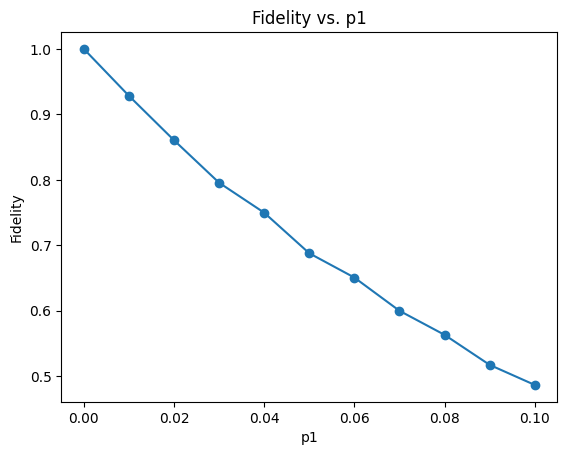

In [38]:
#plot the fidelity as a function of p1
plt.plot(p1, fidelities, 'o-')
plt.xlabel('p1')
plt.ylabel('Fidelity')
plt.title('Fidelity vs. p1')
plt.show()


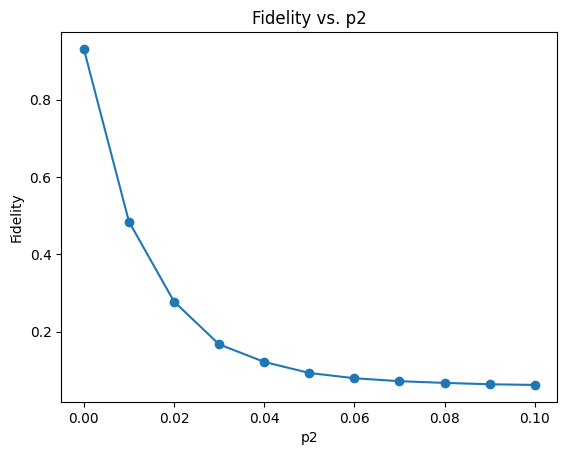

In [39]:
# Simulate the circuit with noise P2 only and get the result
a = 3
b = 5
p1 = 0.01
p2 = np.linspace(0, 0.1, 11)
shots = 8192
results = []
for p in p2:
    noise_model = add_pauli_noise(p1, p)
    noisy_simulator = AerSimulator(noise_model=noise_model)
    noisy_circuit = transpile(qc_no_noise, noisy_simulator)
    result = noisy_simulator.run(noisy_circuit, shots=shots).result()
    counts = result.get_counts()
    results.append(counts)

# Calculate fidelity for each noisy result
fidelities = [calculate_fidelity(ideal_probs, counts) for counts in results]

#plot the fidelity as a function of p2
plt.plot(p2, fidelities, 'o-')
plt.xlabel('p2')
plt.ylabel('Fidelity')
plt.title('Fidelity vs. p2')
plt.show()
    

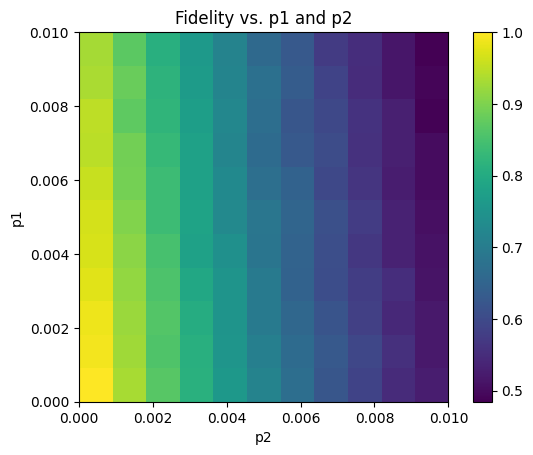

In [41]:
# Simulate the circuit with noise P1 and P2 and get the result
#use meshgrid to create a 2D grid of p1 and p2
a = 3
b = 5
p1 = np.linspace(0, 0.01, 11)
p2 = np.linspace(0, 0.01, 11)
shots = 8192
results = []
for p1_val in p1:
    for p2_val in p2:
        noise_model = add_pauli_noise(p1_val, p2_val)
        noisy_simulator = AerSimulator(noise_model=noise_model)
        noisy_circuit = transpile(qc_no_noise, noisy_simulator)
        result = noisy_simulator.run(noisy_circuit, shots=shots).result()
        counts = result.get_counts()
        results.append(counts)

# Calculate fidelity for each noisy result
fidelities = [calculate_fidelity(ideal_probs, counts) for counts in results]

#reshape the fidelities to a 2D grid
fidelities = np.array(fidelities).reshape(len(p1), len(p2))

#plot the fidelity as a function of p1 and p2
plt.imshow(fidelities, extent=(p2.min(), p2.max(), p1.min(), p1.max()), origin='lower')
plt.colorbar()
plt.xlabel('p2')
plt.ylabel('p1')
plt.title('Fidelity vs. p1 and p2')
plt.show()


### Analysis of Noise Effects on Quantum Addition

#### How Does the Noise Affect the Results?
- **Accuracy Reduction**: As noise levels increase, the probability of measuring the correct sum decreases. Noise introduces errors in the gate operations, which can alter the final state, leading to incorrect outcomes.
- **Reduced Fidelity**: Fidelity, which measures how close the noisy quantum state is to the ideal state, decreases as noise levels increase. This indicates that noise causes significant deviations from the expected results.

#### Is There a Way to Decrease the Effect of Noise?
- **Error Mitigation and Correction**: Using quantum error correction techniques can help detect and correct errors, thereby reducing the impact of noise.
- **Gate Count Reduction**: Optimizing the quantum circuit to use fewer gates can significantly reduce noise since each gate has an associated probability of introducing errors.
- **Noise-Aware Compilation**: Techniques such as noise-aware routing and scheduling can reduce the impact of noise by choosing less noisy qubits and operations.
- **Pulse Optimization**: Adjusting pulse sequences to be more robust against decoherence can also mitigate noise.

#### How Does the Number of Gates Affect the Results?
- **Cumulative Noise**: Each gate introduces a certain amount of error. As the number of gates increases, the cumulative effect of these errors grows, which leads to a lower probability of getting the correct output.
- **Complexity**: More gates imply a more complex quantum state, which increases the likelihood of errors accumulating and causing significant deviations from the desired result.